In [120]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import neo
from pathlib import Path

In [121]:
def plot_population_spikes(filename):
    spike_bin_width_ms = 20
    t_min = None
    t_max = None
    result_file = Path(filename)
    population_results = neo.NeoMatlabIO(result_file).read()
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    colormap = ["#1E212B", "#FF8427", "#4D8B31", "#FFC800"]
    last_population_name = ""
    colormap_i = -1
    master_spike_list = []
    for i, train in enumerate(population_results[0].segments[0].spiketrains):
        if t_min is None and t_max is None:
            t_min = train.t_start
            t_max = train.t_stop
        if train.annotations["source_population"] != last_population_name:
            colormap_i = (colormap_i + 1) % len(colormap)
            last_population_name = train.annotations["source_population"]
        axs[0].plot(train, np.ones(len(train)) * i, '.', markersize=2, color=colormap[colormap_i])
        axs[0].set_xlabel("Time [ms]")
        axs[0].set_ylabel("neuron number")
        axs[0].set_title(result_file.stem)
        master_spike_list.append(train.as_array())
    time_bins = np.arange(float(t_min), float(t_max), spike_bin_width_ms)
    binned_spikes = np.zeros(time_bins.shape)
    for i, start in enumerate(time_bins):
        if i == len(time_bins) - 1:
            end = float(t_max) + spike_bin_width_ms
        else:
            end = time_bins[i + 1]
        binned_spikes[i] = np.sum([np.count_nonzero(np.bitwise_and(start <= st, st < end)) for st in master_spike_list])
    axs[1].plot(time_bins, binned_spikes)
    axs[1].set_xlabel("Time [ms]")
    axs[1].set_ylabel(f"Spikes / {spike_bin_width_ms} ms")

In [122]:
def plot_d_layer_lfp(d_layer_file, ci_file):
    d_layer_results = neo.NeoMatlabIO(Path(d_layer_file)).read()
    ci_results = neo.NeoMatlabIO(Path(ci_file)).read()
    sigma = 0.27 
    r = 100 * 1e-6
    epsc = d_layer_results[0].segments[0].analogsignals[1]
    ipsc = ci_results[0].segments[0].analogsignals[1]
    lfp = (np.mean(epsc, axis=-1) + np.mean(ipsc, axis=-1)) / (4 * np.pi * sigma * r)
    
    if epsc.sampling_rate == ipsc.sampling_rate:
        fs = epsc.sampling_rate * 1000
    else:
        fs = 1
        
    fxx, psd = signal.welch(lfp, fs, nperseg=10000)
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    axs[0].plot(lfp / 1000)
    axs[0].set_xlabel("Samples")
    axs[0].set_ylabel("LFP [mV?]")
    
    axs[1].plot(fxx, psd)
    axs[1].set_xlabel("Frequency [Hz]")
    axs[1].set_ylabel("PSD [mV? ** 2 / Hz]")
    axs[1].set_xlim([0, 100])

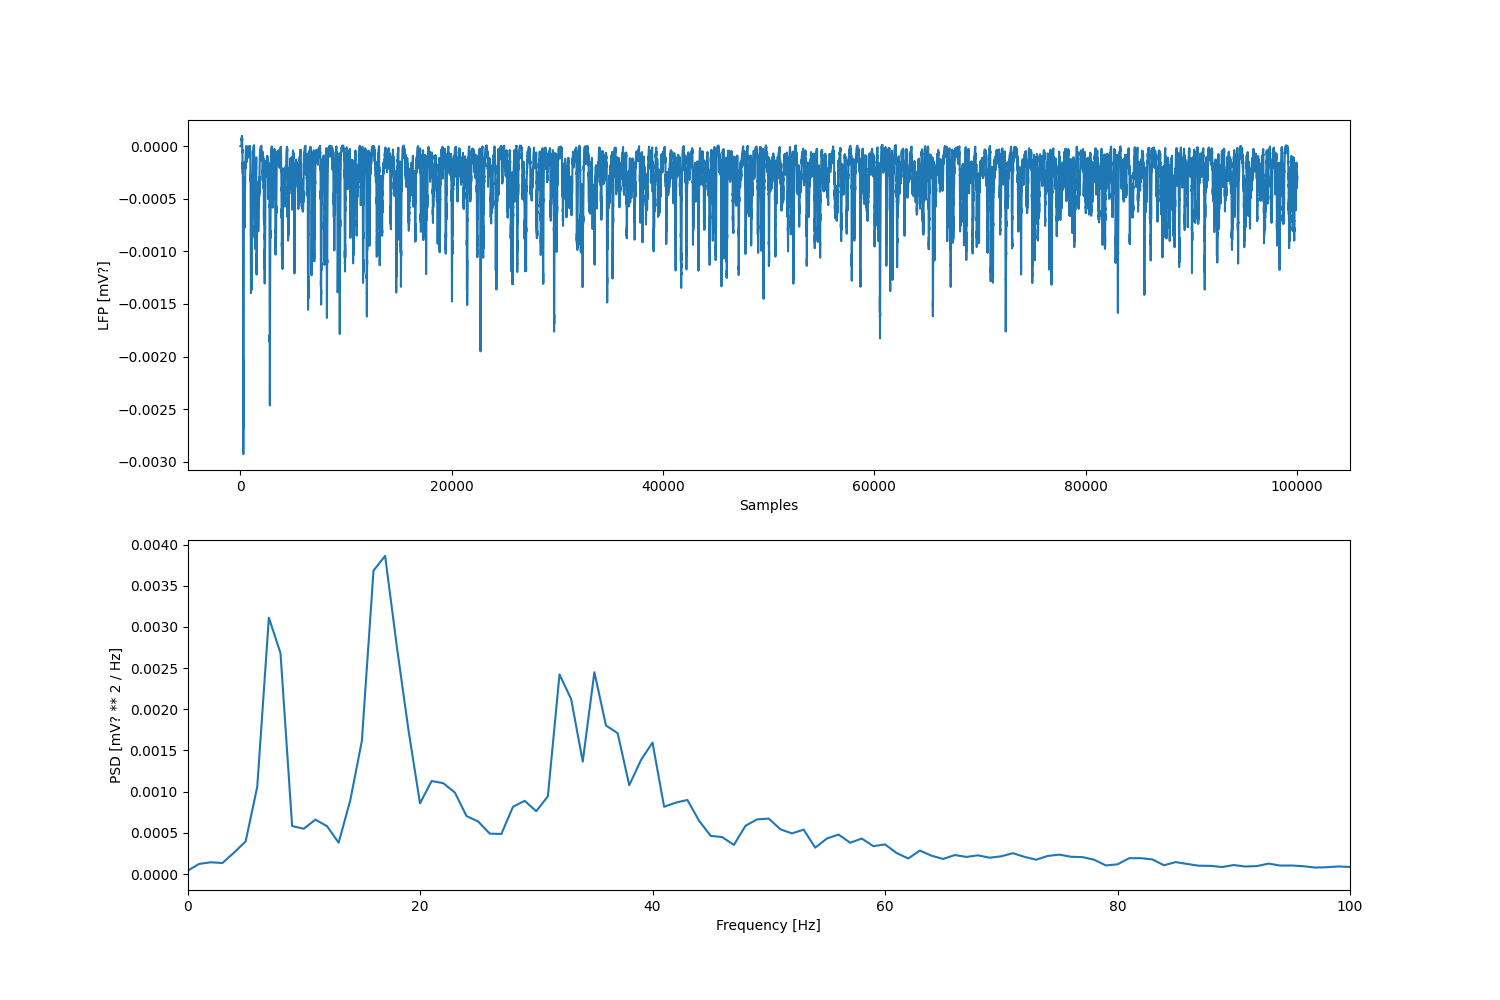

In [125]:
%matplotlib widget
plot_d_layer_lfp("Results/D_Layer.mat", "Results/CI_Neurons.mat")

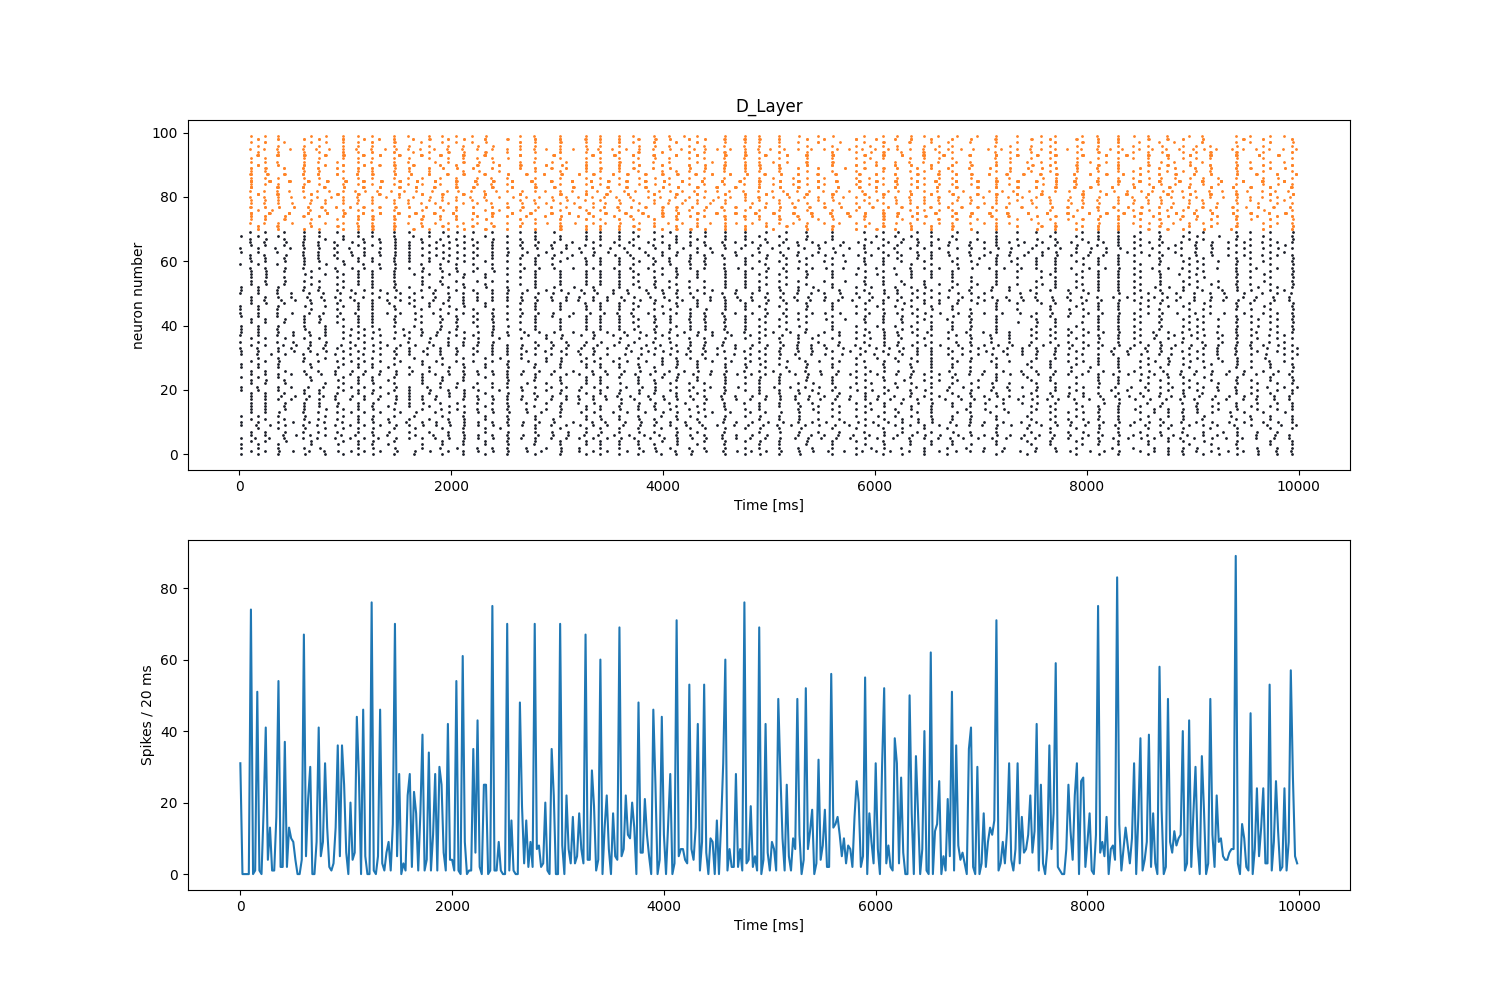

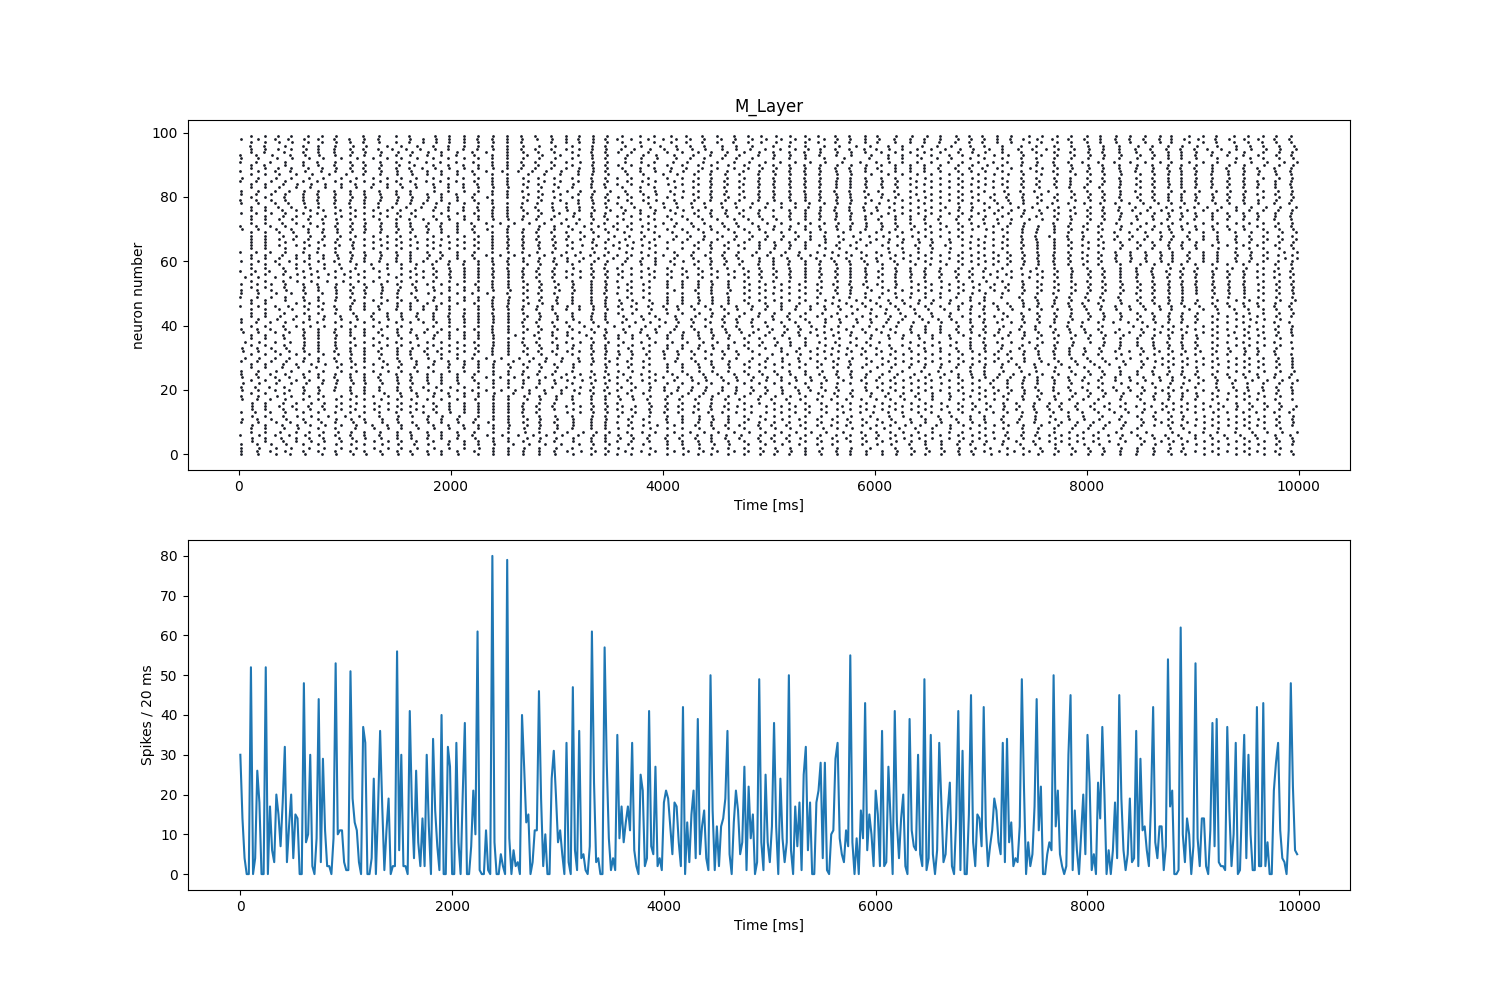

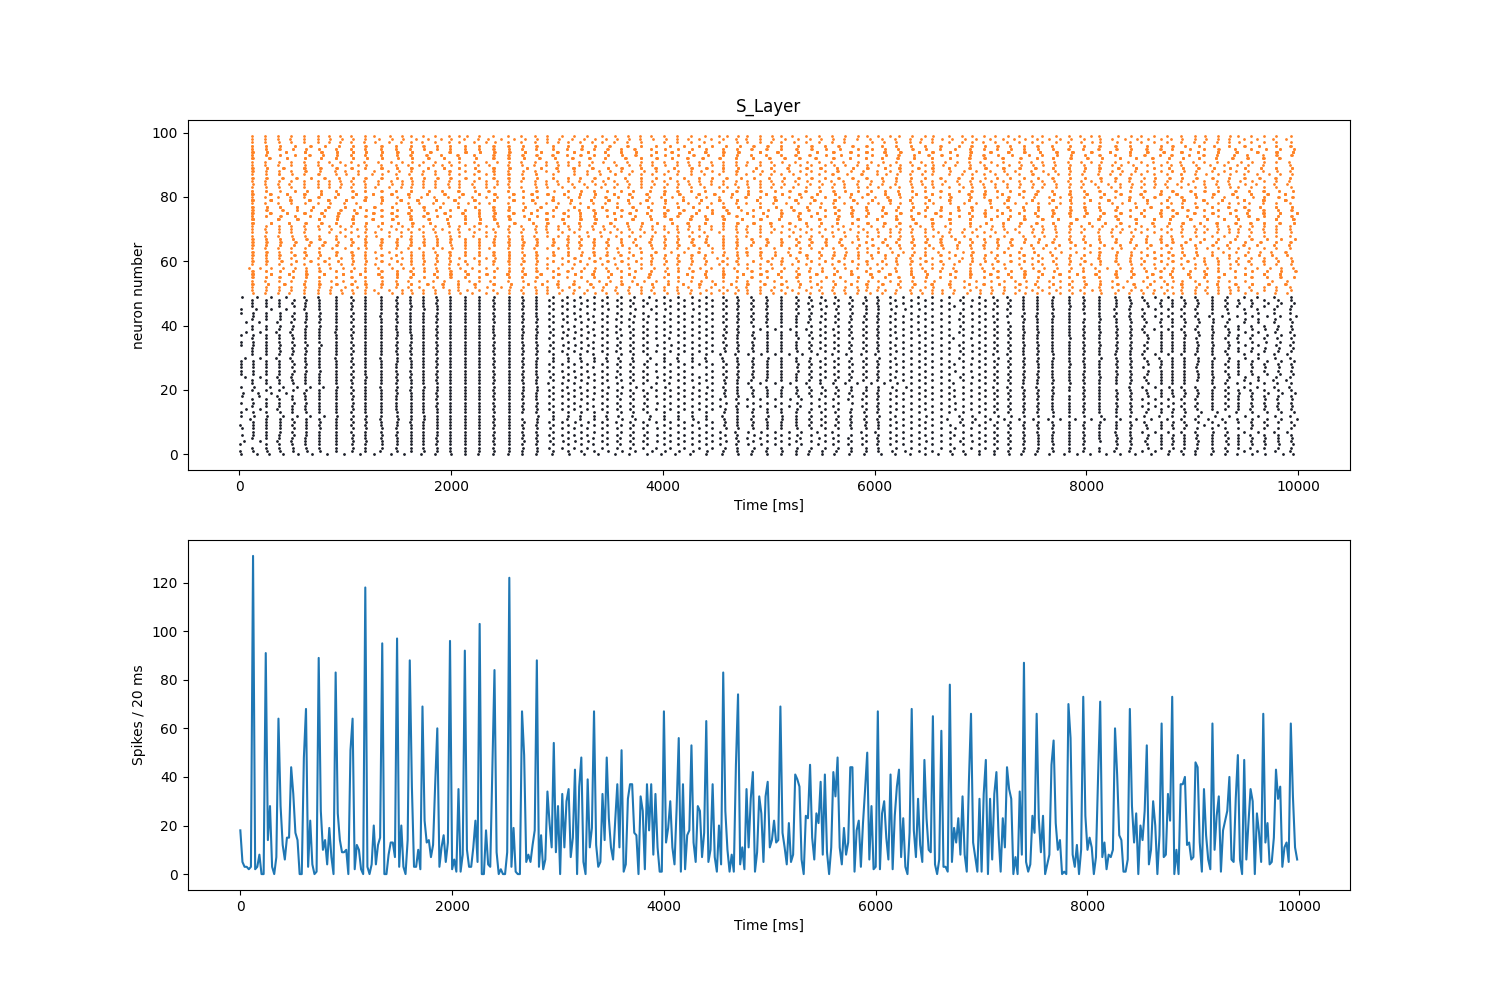

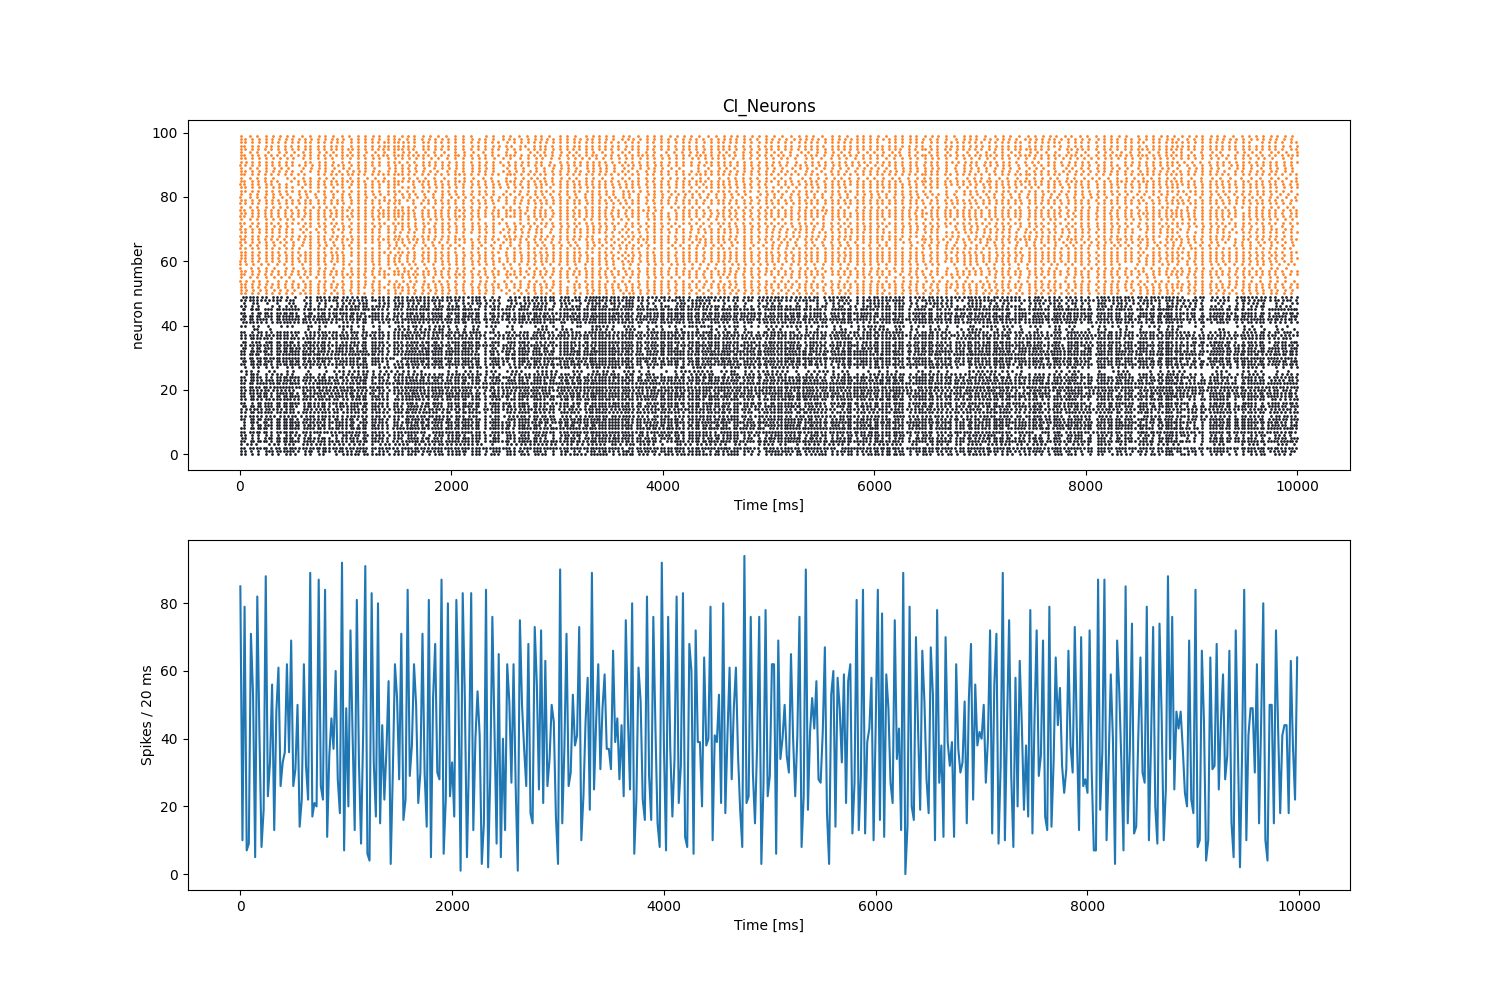

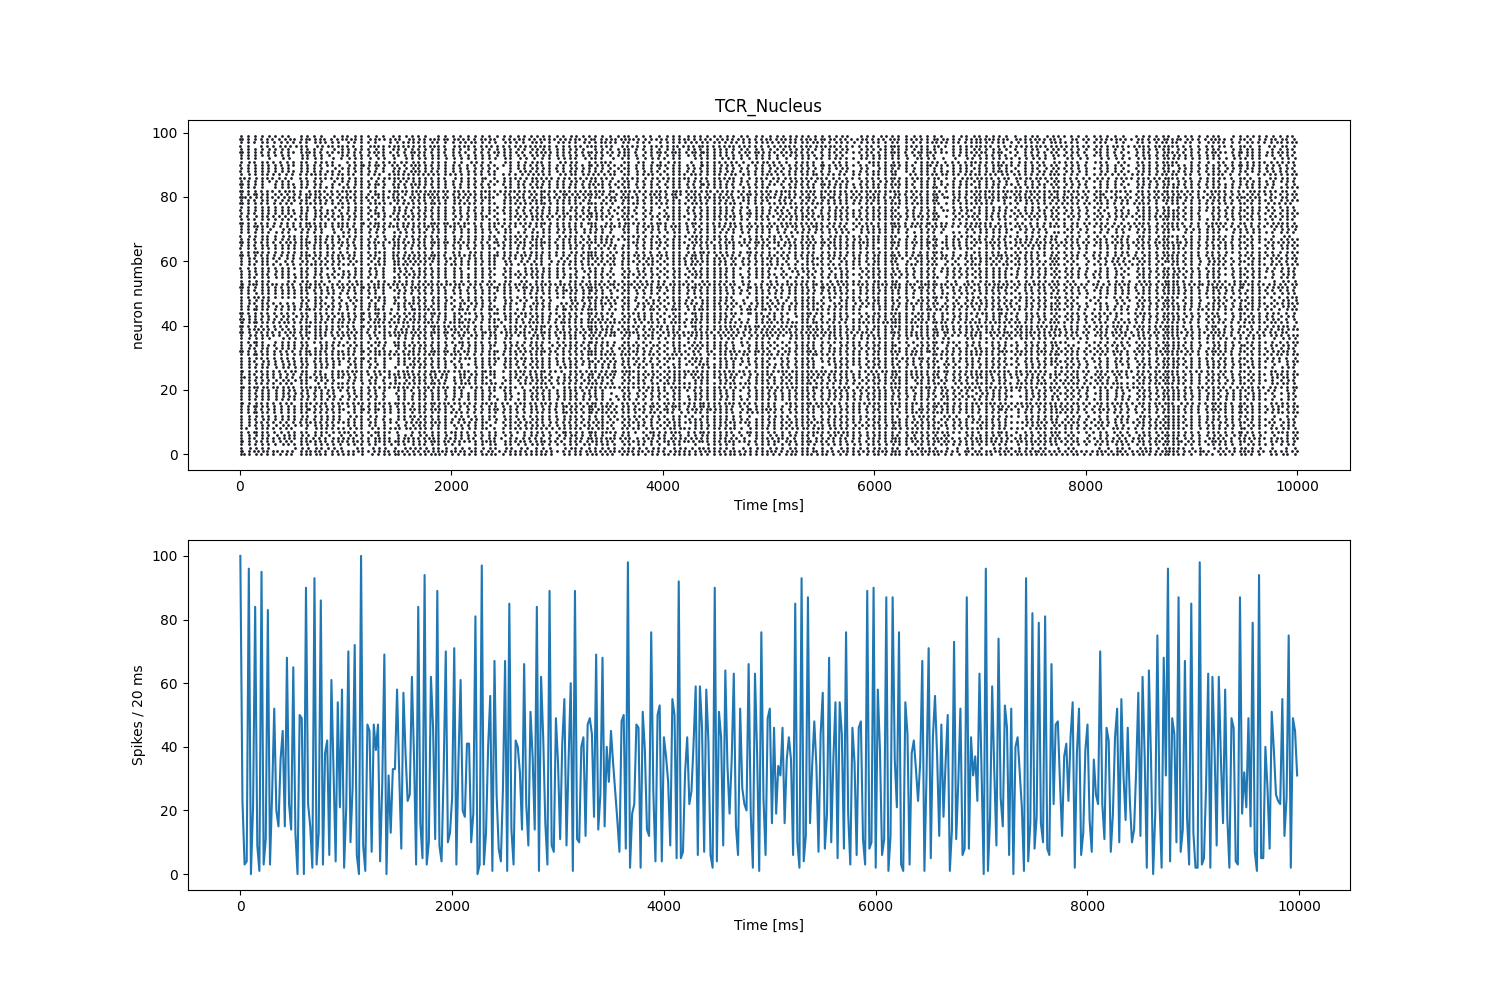

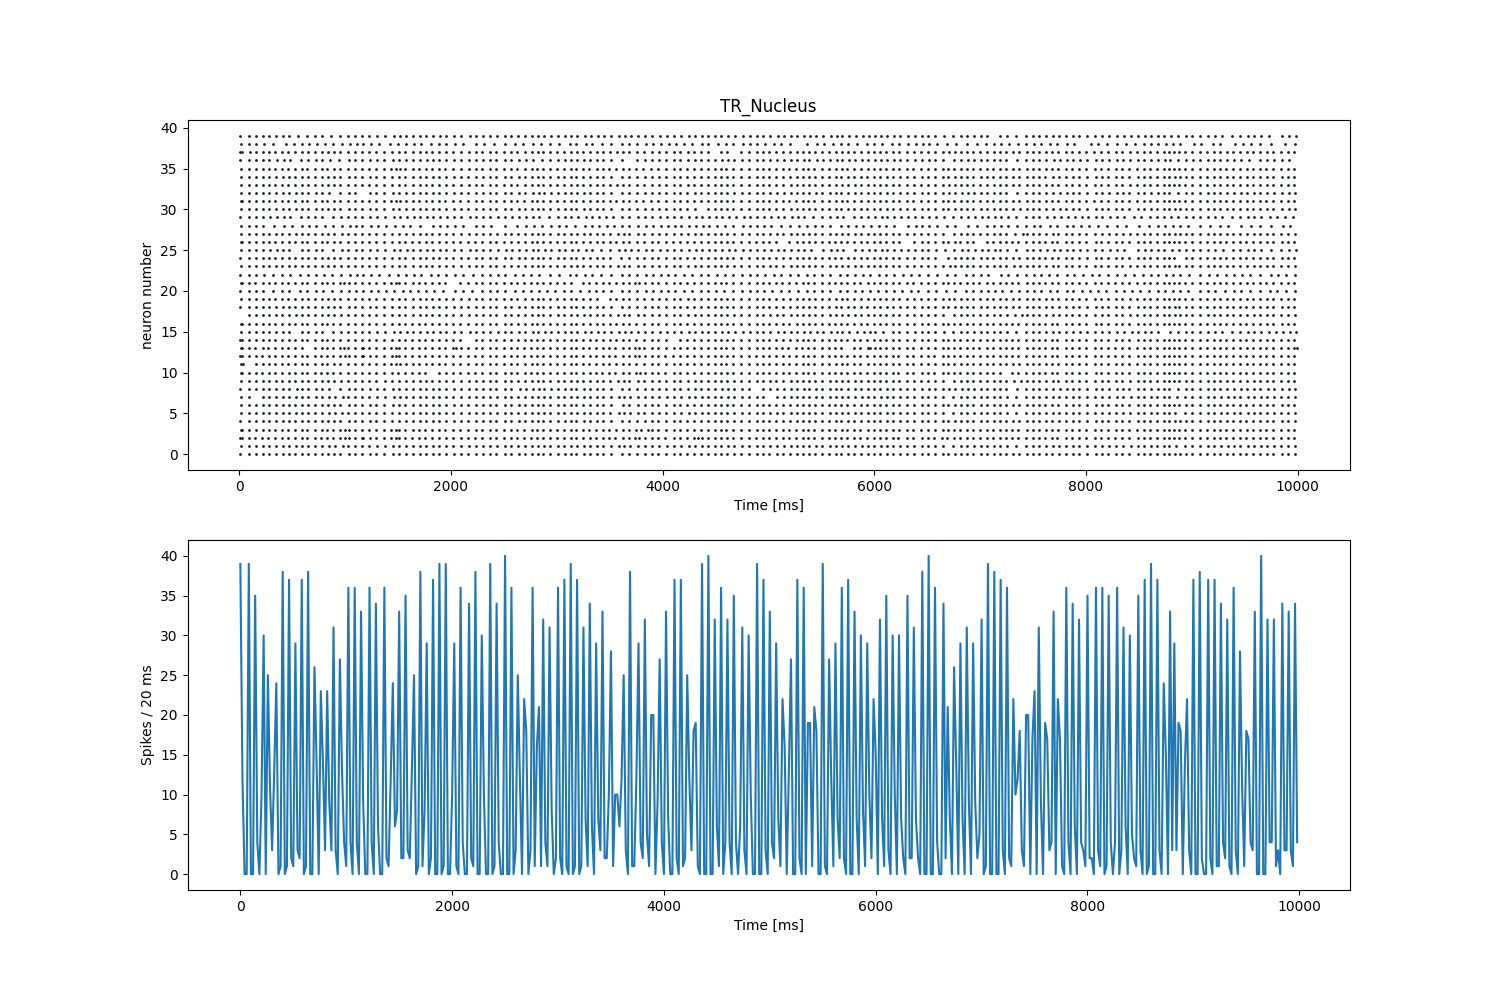

In [124]:
%matplotlib widget
result_files = [
    "Results/D_Layer.mat",
    "Results/M_Layer.mat",
    "Results/S_Layer.mat",
    "Results/CI_Neurons.mat",
    "Results/TCR_Nucleus.mat",
    "Results/TR_Nucleus.mat"
]

for f in result_files:
    plot_population_spikes(f)